In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import *
import torchvision
import torchvision.transforms as transforms

import os, glob
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../')
from src.utils import *

(375, 1242, 3)

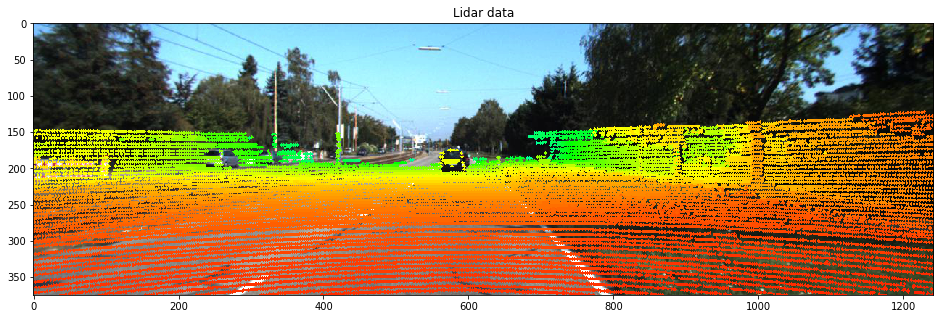

In [4]:
im_left_dir = './data/left_imgs/'
gt_left_dir = './data/left_gt/'
im_right_dir = './data/right_imgs/'
gt_right_dir = './data/right_gt/'

idx = random.randint(0, 10)
im_left = mpimg.imread(os.path.join('../data/right_imgs/2011_09_26_drive_0015_sync', ("{:010}".format(idx) + '.jpg')))
c = os.path.join('../data/right_gt/2011_09_26_drive_0015_sync', ("{:010}".format(idx) + '.npy')) 
d = np.load(c)
show_lidar(im_left, d)

im_left.shape

In [2]:
class KittiStereoLidar(Dataset):
    def __init__(self, im_left_dir, im_right_dir, gt_left_dir, gt_right_dir, \
                 transform=None, augmentation=True):
        self.im_left_dir = im_left_dir
        self.im_right_dir = im_right_dir
        self.gt_left_dir = gt_left_dir
        self.gt_right_dir = gt_right_dir
        
        self.im_left_dir.sort()
        self.im_right_dir.sort()
        self.gt_left_dir.sort()
        self.gt_right_dir.sort()
        
        self.transform = transform
        self.augmentation = augmentation
        
    def __getitem__(self, index):
        iml = Image.open(self.im_left_dir[index])
        imr = Image.open(self.im_right_dir[index])
        gtl = self.gt_left_dir[index]
        gtr = self.gt_right_dir[index]

        if self.transform:
            iml = self.transform(iml)
            imr = self.transform(imr)
            
        if self.augmentation:
            iml = self.augmentation_color_space(iml)
            iml = self.augmentation_gaussian_noise(iml)

            imr = self.augmentation_color_space(imr)
            imr = self.augmentation_gaussian_noise(imr)

        return iml, imr, gtl, gtr

    def augmentation_gaussian_noise(self, img, mag=0.5, p=0.2): #3*h*w
        r = np.random.random()
        if r < p:
            img += (mag * torch.rand(3, img.shape[1], img.shape[2]))
            img = img / (1 + mag)
        return img
    
    def augmentation_color_space(self, img, p=0.2): #remove 1 color channel randomly
        r = np.random.random()
        if r < p:
            z = np.random.randint(0,3)
            img[z,:,:] *= 0

            return img
    
    def __len__(self):
        return len(self.im_left_dir)

im_left_dir=glob.glob("../data/left_imgs/2011_09_26_drive_0014_sync/*")
im_right_dir = glob.glob("../data/right_imgs/2011_09_26_drive_0014_sync/*")
gt_left_dir=glob.glob("../data/left_gt/2011_09_26_drive_0014_sync/*")
gt_right_dir=glob.glob("../data/right_gt/2011_09_26_drive_0014_sync/*")

kitti_ds = KittiStereoLidar(
    im_left_dir=im_left_dir, 
    im_right_dir=im_right_dir,
    gt_left_dir=gt_left_dir, 
    gt_right_dir=gt_right_dir,
    transform=transforms.Compose([transforms.Resize((192,640)),
                                  transforms.RandomGrayscale(p=0.2),
                                  transforms.ToTensor()]),
    augmentation=True)

batch_size = 4
train_loader = DataLoader(dataset=kitti_ds, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=4)
 
dataiter = iter(train_loader)

../data/right_gt/2011_09_26_drive_0014_sync/0000000103.npy


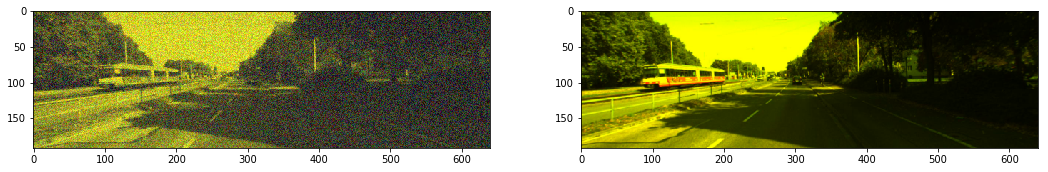

In [16]:
def imshow(iml, imr):
    npl = iml.numpy()
    npr = imr.numpy()
    f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))
    ax1.imshow(np.transpose(npl, (1, 2, 0)))
    ax2.imshow(np.transpose(npr, (1, 2, 0)))

images_l, images_r, scans_l, scans_r = dataiter.next()
idx = random.randint(0, batch_size - 1)
imshow(images_l[idx], images_r[idx])

print(scans_r[idx])
#scr = np.load(scans_l[idx])
#npr = np.transpose(images_l[idx].numpy(), (1,2,0))
#show_lidar(npr, scr)

In [63]:
im_left = mpimg.imread(os.path.join('../data/right_imgs/2011_09_26_drive_0035_sync', ("{:010}".format(22) + '.jpg')))

In [5]:
im_hls = cv2.cvtColor(im_left, cv2.COLOR_RGB2HLS)

In [14]:
im_hls[:,:,1] = np.ones([im_hls.shape[0], im_hls.shape[1]])*np.mean(im_hls[:,:,1])

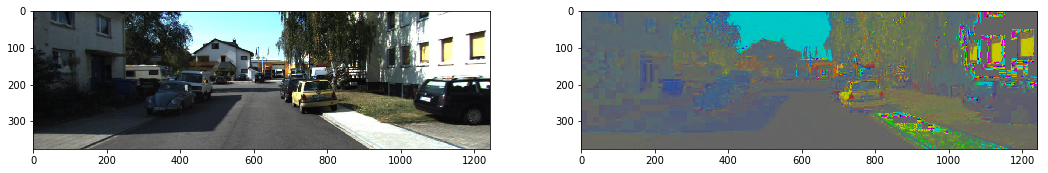

In [15]:
im_processed = cv2.cvtColor(im_hls, cv2.COLOR_HLS2RGB)
f, (ax1, ax2)=plt.subplots(1,2,figsize=(18,6))
ax1.imshow(im_left)
ax2.imshow(im_processed)
plt.show()

In [18]:
class DummyDataset(Dataset):
    def __init__(self, indices, transform=None):
        self.indices=indices
        self.transform = transform
        
    def __getitem__(self, index):
        index2 = (self.indices[index]**2)
        return index2
    
    def __len__(self):
        return len(self.indices)

dummy_ds = DummyDataset(range(20))

In [32]:
def create_indices(length):
    indices = list(range(length))
    np.random.shuffle(indices)

    train_split = int(np.floor(0.5 * len(indices)))
    train_indices = indices[:train_split]
    return train_indices

In [33]:
def create_dataloader(indices):
    train_sampler = SubsetRandomSampler(indices)#shuffling featured already
    train_loader = DataLoader(dataset=dummy_ds, 
                              batch_size=4, 
                              sampler=train_sampler,
                              shuffle=False, 
                              num_workers=6)
    return train_loader

In [34]:
for epoch in range(2):
    train_loader = create_dataloader(create_indices(20))
    print("epoch:{}".format(epoch+1))
    for xx in train_loader:
        print(xx)


epoch:1
tensor([  81,   49,  144,  169])
tensor([  36,   25,    1,  256])
tensor([ 64,  16])
epoch:2
tensor([ 289,  196,  324,   64])
tensor([ 121,   16,  361,    9])
tensor([ 169,  256])
